In [1]:
import uproot
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import ROOT
import time
import math
import helpfunction as helper
from __future__ import division

Welcome to JupyROOT 6.10/08


In [2]:
#inputdir = '/home/tmettler/Desktop/ub_data/ub_xsec/ConsolidatedSliceAnalyser/ext/'

# CRTinBNB tagger, Overlay or MC

In [3]:
fidvol_vtx = [10,10,10,10,10,50] 
fidvol_end = [5,5,5,5,5,5]

lower = [-1.55, -115.53, 0.1]
upper = [254.8, 117.47, 1036.9]


mass_mu = 0.106
kin_min = 0.02
kin_min_mu = kin_min + mass_mu

gr = (1 + 5 ** 0.5) / 2

In [4]:
def eventHash(df):
    return df.apply(lambda x: hash(tuple(x)), axis = 1)

def inTPC_mask(df, str_x, str_y, str_z, fidvol=[0]*6):
    global upper, lower
    mask_x = df[str_x].between(lower[0]+fidvol[0], upper[0]-fidvol[1])
    mask_y = df[str_y].between(lower[1]+fidvol[2], upper[1]-fidvol[3])
    mask_z = df[str_z].between(lower[2]+fidvol[4], upper[2]-fidvol[5])
    mask = mask_x & mask_y & mask_z
    return mask

def inTPC_df(df, str_x, str_y, str_z, fidvol=[0]*6):
    mask = inTPC_mask(df, str_x, str_y, str_z, fidvol)
    return df[mask]

In [5]:
#inputdir = '/home/tmettler/Desktop/ub_data/cc_filter/'
#outputdir = '/home/tmettler/Desktop/ub_data/cc_filter/numuPlots/'

#inputdir = '/home/tmettler/Desktop/ub_data/cc_filter/run1/'
#outputdir = '/home/tmettler/Desktop/ub_data/cc_filter/run1/numuPlots/'
#wouter:
inputdir = '/home/tmettler/Desktop/ub_data/cc_filter/data_wouter/'
outputdir = '/home/tmettler/Desktop/ub_data/cc_filter/data_wouter/numuPlots/'

try:
    os.stat(outputdir)
except:
    os.mkdir(outputdir)
#filename = 'flashID_tree_overlay.root'
#filename = 'flashID_bnb_tree.root' ##POT = 5.536253 E20 POT
#Wouter
filename = 'NuCC_nu_overlay.root' 

isMC = 1
useT1 = 0
nuCCanalyser = 'nuCCAnalyser'

In [6]:
test = ROOT.TChain(nuCCanalyser + "/Event","Event")
test.Add( inputdir + filename)

#test.ls()
print "Number of Entries:", test.GetEntries()
# uncomment one of them
cutname = 'has_nuslice'

cut = ' && ' + cutname
#cut = ''

title_cut = ''
if(cut!=''):
    title_cut = ' with '+ cutname
    

Number of Entries: 77983


Warning in <TClass::Init>: no dictionary for class ROOT::TIOFeatures is available


In [7]:
ROOT.gStyle.SetOptStat(0)
c1 = ROOT.TCanvas("","",1600,1200)
c1.SetGrid(1)
c1.SetLeftMargin(0.14)
c1.SetRightMargin(0.18)
c1.SetBottomMargin(0.14)

In [8]:
file_tree = {}
dict_names = ['overlay','on','off']

file_tree['overlay'] = {}
file_tree['overlay']['event'] = uproot.open(inputdir+filename)['nuCCAnalyser'+'/Event']
file_tree['overlay']['daughter'] = uproot.open(inputdir+filename)['nuCCAnalyser'+'/Daughters']
file_tree['overlay']['sliceid'] = uproot.open(inputdir+filename)['pandoraSliceId'+'/events']
file_tree['overlay']['slices'] = uproot.open(inputdir+filename)['pandoraSliceId'+'/slices']
print file_tree['overlay']['event'].numentries
print 'length of event tree', file_tree['overlay']['event'].numentries
print file_tree['overlay']['sliceid'].numentries

77983
length of event tree 77983
172921


In [9]:
for name in file_tree['overlay'] :
    print
    print('*** ', name, ' ***')
    print([c.decode('UTF-8') for c in file_tree['overlay'][name].keys()])


('*** ', 'sliceid', ' ***')
[u'run', u'subRun', u'event', u'evt_time_sec', u'evt_time_nsec', u'nFlashes', u'nFlashesInBeamWindow', u'hasBeamFlash', u'nSlices', u'nSlicesAfterPrecuts', u'foundATargetSlice', u'targetSliceMethod', u'bestCosmicMatch', u'cosmicMatchHypothesis', u'nuInteractionType', u'nuCCNC', u'nuEnergy', u'leptonEnergy', u'nuInteractionTime', u'nuPdgCode', u'nuVertexX', u'nuVertexY', u'nuVertexZ']

('*** ', 'daughter', ' ***')
[u'event', u'run', u'subrun', u'evt_time_sec', u'evt_time_nsec', u'hitsU', u'hitsV', u'hitsY', u'caloU', u'caloV', u'caloY', u'hitsSps', u'generation', u'track_score', u'is_shower', u'is_track', u'has_shower_daughter', u'is_track_daughter', u'vx', u'vy', u'vz', u'vtx_distance', u'track_length', u'track_endx', u'track_endy', u'track_endz', u'track_dirx', u'track_diry', u'track_dirz', u'track_mcs_mom', u'track_mcs_err', u'track_mcs_ll', u'track_chi2_proton', u'track_chi2_muon', u'shower_length', u'shower_openangle', u'shower_dirx', u'shower_diry', u'

In [10]:
entry_Event = file_tree['overlay']['event'].keys()
print entry_Event
entry_SliceId = file_tree['overlay']['sliceid'].keys()
entry_Daughter = file_tree['overlay']['daughter'].keys()
entry_Slices = file_tree['overlay']['slices'].keys()

cols = ['mc_nu_vx', 'mc_nu_vy', 'mc_nu_vz', 'mc_nu_lepton_energy', 'mc_nu_lepton_theta','mc_nu_ccnc', 'mc_nu_pdg',\
        'mc_nu_lepton_px','mc_nu_lepton_py','mc_nu_lepton_pz']

tree_Event = file_tree['overlay']['event'].pandas.df(cols)
#tree_SliceId = file_tree['overlay']['sliceid'].pandas.df(entry_SliceId)
tree_Daughter = file_tree['overlay']['daughter'].pandas.df(entry_Daughter)
#tree_Slices = file_tree['overlay']['slices'].pandas.df(entry_Slices)


tree_Event['mc_nu_fid_vol'] = inTPC_mask( tree_Event, 'mc_nu_vx', 'mc_nu_vy', 'mc_nu_vz', fidvol=fidvol_vtx)
nu_tpc_mask = inTPC_mask( tree_Event, 'mc_nu_vx', 'mc_nu_vy', 'mc_nu_vz',fidvol=fidvol_vtx)
#df_nu_event['mc_nu_fid_vol'] = inTPC_mask( df_nu_event, 'mc_nu_vx', 'mc_nu_vy', 'mc_nu_vz', fidvol=fidvol_vtx)
nu_sig_mask = tree_Event.eval('~mc_nu_ccnc & abs(mc_nu_pdg)==14 & mc_nu_fid_vol')
tree_Event['nu_sig_mask'] = tree_Event.eval('~mc_nu_ccnc & abs(mc_nu_pdg)==14 & mc_nu_fid_vol')
#mc_nu_lepton_energy>@kin_min_mu 120835 98474
nu_sig_mask_nue = tree_Event.eval('~mc_nu_ccnc & abs(mc_nu_pdg)==12 & mc_nu_fid_vol')
print 'Total number of events:', file_tree['overlay']['event'].numentries
print 'Total events with vertex in active volume:', sum(nu_tpc_mask)
print 'Total events numu cc:', sum(nu_sig_mask)
print 'Total events nue cc:', sum(nu_sig_mask_nue) 

['event', 'run', 'subrun', 'evt_time_sec', 'evt_time_nsec', 'numpfp', 'hitsU', 'hitsV', 'hitsY', 'caloU', 'caloV', 'caloY', 'hitsSps', 'num_primary_daughters', 'num_daughters', 'num_showers', 'num_tracks', 'daughters_stored', 'nu_vx', 'nu_vy', 'nu_vz', 'nu_pdg', 'num_neutrinos', 'mc_nu_vx', 'mc_nu_vy', 'mc_nu_vz', 'mc_nu_vx_sce', 'mc_nu_vy_sce', 'mc_nu_vz_sce', 'mc_nu_energy', 'mc_nu_px', 'mc_nu_py', 'mc_nu_pz', 'mc_nu_lepton_energy', 'mc_nu_lepton_px', 'mc_nu_lepton_py', 'mc_nu_lepton_pz', 'mc_nu_lepton_theta', 'mc_nu_time', 'mc_nu_pdg', 'mc_nu_interaction_type', 'mc_nu_ccnc', 'mc_nu_vtx_distance', 'num_matched_daughters', 'cosmic_matched', 'mc_nu_daughter_matched', 'mc_nu_daughter_pdg', 'mc_nu_daughter_energy']
Total number of events: 77983
Total events with vertex in active volume: 45476
Total events numu cc: 37202
Total events nue cc: 264


In [11]:
start = time.time()
start_mask = inTPC_mask(tree_Daughter, 'vx', 'vy', 'vz', fidvol_vtx)

tree_Daughter['hash'] = eventHash(tree_Daughter[['evt_time_sec', 'evt_time_nsec']])

df_event = file_tree['overlay']['event'].pandas.df(['evt_time_sec','evt_time_nsec','nu_pdg', 'caloY','num_tracks'])
df_event['hash'] = eventHash(df_event[['evt_time_sec', 'evt_time_nsec']])
mapper = dict(zip(df_event['hash'],df_event['nu_pdg']))
tree_Daughter['nu_pdg'] = tree_Daughter['hash'].map(mapper)
mapper = dict(zip(df_event['hash'],df_event['caloY']))
tree_Daughter['caloY'] = tree_Daughter['hash'].map(mapper)
mapper = dict(zip(df_event['hash'],df_event['num_tracks']))
tree_Daughter['num_tracks'] = tree_Daughter['hash'].map(mapper)
mapper = dict(zip(df_event['hash'],tree_Event['nu_sig_mask']))
tree_Daughter['nu_sig_mask'] = tree_Daughter['hash'].map(mapper)

df_slices = file_tree['overlay']['slices'].pandas.df(['evt_time_sec','evt_time_nsec','topologicalScore', 'flashMatchScore', 'isTaggedAsTarget', 'minCRTdist'])
df_slices = df_slices.query('isTaggedAsTarget')
df_slices['hash'] = eventHash(df_slices[['evt_time_sec', 'evt_time_nsec']])
mapper = dict(zip(df_slices['hash'],df_slices['topologicalScore']))
tree_Daughter['topologicalScore'] = tree_Daughter['hash'].map(mapper)
mapper = dict(zip(df_slices['hash'],df_slices['flashMatchScore']))
tree_Daughter['flashMatchScore'] = tree_Daughter['hash'].map(mapper)
mapper = dict(zip(df_slices['hash'],df_slices['minCRTdist']))
tree_Daughter['minCRTdist'] = tree_Daughter['hash'].map(mapper)

print tree_Daughter.shape
end = time.time()
print("Passed time: {0:0.1f}s".format(end - start))

(188570, 65)
Passed time: 9.9s


In [12]:
start = time.time()
tree_Daughter['longest_track_length'] = tree_Daughter.groupby(['hash'])['track_length'].transform(max)
# there can be only one muon candidate per event!
tree_Daughter['muon_candidate'] = tree_Daughter.eval('track_score>0.9 & vtx_distance<5 & longest_track_length==track_length')
tree_Daughter['all_muon_candidate'] = tree_Daughter.groupby(['hash'])['muon_candidate'].transform(any)

df_all_event = file_tree['overlay']['sliceid'].pandas.df(['evt_time_sec','evt_time_nsec','bestCosmicMatch'])
df_all_event['hash'] = eventHash(df_all_event[['evt_time_sec', 'evt_time_nsec']])
mapper = dict(zip(df_all_event['hash'],df_all_event['bestCosmicMatch']))
tree_Daughter['bestCosmicMatch'] = tree_Daughter['hash'].map(mapper)

if isMC == 1:
    mapper = dict(zip(df_event['hash'],nu_tpc_mask))
    tree_Daughter['mc_nu_in_tpc'] = tree_Daughter['hash'].map(mapper)
    mapper = dict(zip(df_event['hash'],nu_sig_mask))
    tree_Daughter['mc_nu_cc_sig'] = tree_Daughter['hash'].map(mapper)
    mapper = dict(zip(df_event['hash'],file_tree['overlay']['event'].array('mc_nu_lepton_energy')))
    tree_Daughter['mc_nu_lepton_energy'] = tree_Daughter['hash'].map(mapper)
    mapper = dict(zip(df_event['hash'],file_tree['overlay']['event'].array('mc_nu_lepton_theta')))
    tree_Daughter['mc_nu_lepton_theta'] = tree_Daughter['hash'].map(mapper)
    mapper = dict(zip(df_event['hash'],file_tree['overlay']['event'].array('mc_nu_lepton_px')))
    tree_Daughter['mc_nu_lepton_px'] = tree_Daughter['hash'].map(mapper)
    mapper = dict(zip(df_event['hash'],file_tree['overlay']['event'].array('mc_nu_lepton_py')))
    tree_Daughter['mc_nu_lepton_py'] = tree_Daughter['hash'].map(mapper)
    mapper = dict(zip(df_event['hash'],file_tree['overlay']['event'].array('mc_nu_lepton_pz')))
    tree_Daughter['mc_nu_lepton_pz'] = tree_Daughter['hash'].map(mapper)
    mapper = dict(zip(df_event['hash'],file_tree['overlay']['event'].array('mc_nu_vx')))
    tree_Daughter['mc_nu_vx'] = tree_Daughter['hash'].map(mapper)
    mapper = dict(zip(df_event['hash'],file_tree['overlay']['event'].array('mc_nu_vy')))
    tree_Daughter['mc_nu_vy'] = tree_Daughter['hash'].map(mapper)
    mapper = dict(zip(df_event['hash'],file_tree['overlay']['event'].array('mc_nu_vz')))
    tree_Daughter['mc_nu_vz'] = tree_Daughter['hash'].map(mapper)
end = time.time()
print("Passed time: {0:0.1f}s".format(end - start))

#print tree_Daughter
print tree_Daughter.shape
#num_Daughter_nue = len(tree_Daughter.query('nu_pdg==12'))

Passed time: 43.0s
(188570, 79)


In [13]:
tree_Daughter['start_contained'] = start_mask
#print len(tree_Daughter)
tree_Daughter_nuCC = tree_Daughter.query('mc_nu_cc_sig')

query_event = 'nu_pdg==14 & start_contained'
query_event = query_event +' & track_length>20'
# additinal cuts:
add_query = '& track_score>0.97 & vtx_distance<5 & longest_track_length==track_length'
query_event += add_query
eff = len(tree_Daughter_nuCC.query(query_event))
query_event_pur = query_event + '& mc_pdg==13'
pur = len(tree_Daughter_nuCC.query(query_event_pur))
print query_event
print "selected events: {}".format(eff),"- {0:0.1f}%".format(eff*100.0/sum(nu_sig_mask)),\
        " purity: {0:0.1f}%".format(pur*100.0/eff)

add_query = '& topologicalScore>0.087 '
query_event += add_query
eff = len(tree_Daughter_nuCC.query(query_event))
query_event_pur = query_event + '& mc_pdg==13'
pur = len(tree_Daughter_nuCC.query(query_event_pur))
print
print add_query
print "selected events: {}".format(eff),"- {0:0.1f}%".format(eff*100.0/sum(nu_sig_mask)),\
        " purity: {0:0.1f}%".format(pur*100.0/eff)

add_query = '& (track_chi2_muon/track_chi2_proton)<0.12'
query_event += add_query
eff = len(tree_Daughter_nuCC.query(query_event))
query_event_pur = query_event + '& mc_pdg==13'
pur = len(tree_Daughter_nuCC.query(query_event_pur))
print
print add_query
print "selected events: {}".format(eff),"- {0:0.1f}%".format(eff*100.0/sum(nu_sig_mask)),\
        " purity: {0:0.1f}%".format(pur*100.0/eff)

add_query = '& track_chi2_proton>100 & track_chi2_muon<20 '
query_event += add_query
eff = len(tree_Daughter_nuCC.query(query_event))
query_event_pur = query_event + '& mc_pdg==13'
pur = len(tree_Daughter_nuCC.query(query_event_pur))
print
print add_query
print "selected events: {}".format(eff),"- {0:0.1f}%".format(eff*100.0/sum(nu_sig_mask)),\
        " purity: {0:0.1f}%".format(pur*100.0/eff)
print 
print 'number of initial events:', sum(nu_sig_mask)
print "number of selected events: {}".format(eff),"- {0:0.1f}%".format(eff*100.0/sum(nu_sig_mask)),\
        " purity: {0:0.1f}%".format(pur*100.0/eff)
#print 'number of selected events:', eff, eff*100.0/sum(nu_sig_mask)

eff_final = eff/sum(nu_sig_mask)
pur_final = pur/eff
print eff_final
print pur_final


nu_pdg==14 & start_contained & track_length>20& track_score>0.97 & vtx_distance<5 & longest_track_length==track_length
selected events: 23086 - 62.1%  purity: 88.7%

& topologicalScore>0.087 
selected events: 21166 - 56.9%  purity: 89.4%

& (track_chi2_muon/track_chi2_proton)<0.12
selected events: 17331 - 46.6%  purity: 93.8%

& track_chi2_proton>100 & track_chi2_muon<20 
selected events: 13833 - 37.2%  purity: 94.1%

number of initial events: 37202
number of selected events: 13833 - 37.2%  purity: 94.1%
0.371834847589
0.940938335864


The denominator (37202,)
The nominator (13833,)
(13833,)
(37202,)


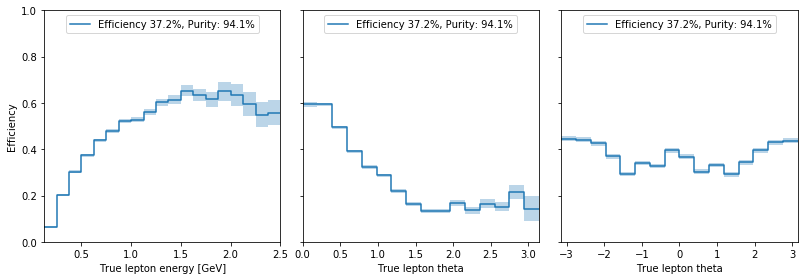

In [14]:
fig,ax=plt.subplots(ncols=3,nrows=1,figsize=(7*gr,4), sharey=True)
purity = pur_final
eff = eff_final
x_min = 0.125
x_max = 2.5
N = 19
denom = tree_Event['mc_nu_lepton_energy'][nu_sig_mask]
print 'The denominator', denom.shape
nom = tree_Daughter_nuCC.query(query_event)['mc_nu_lepton_energy']
print 'The nominator', nom.shape
data = [denom, nom]
edges, _, bins, _, _ = helper.histHelper(N,x_min,x_max,data)
fraq = bins[1]/bins[0]
err = np.sqrt( fraq*(1-fraq)/bins[0] )
fraq= np.append(fraq,fraq[-1])
err = np.append(err,err[-1]) 

ax[0].fill_between(edges, fraq - err, fraq + err, alpha=0.3, step='post')
ax[0].set_xlabel(r'True lepton energy [GeV]')
ax[0].set_ylabel('Efficiency')
ax[0].set_ylim(0,1)
ax[0].set_xlim(x_min, x_max)
ax[0].step(edges, fraq, where='post', label = r'Efficiency {0:0.1f}%, Purity: {1:0.1f}%'.format(eff*100,purity*100))
ax[0].legend(loc='upper center')

# middle
#x_ticks = [0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi]
#x_labels = [r'$0$',r'$\pi/4$',r'$\pi/2$',r'$3\pi/4$',r'$\pi$']
x_min = 0
x_max = np.pi
N = 16
denom = tree_Event['mc_nu_lepton_theta'][nu_sig_mask]
nom = tree_Daughter_nuCC.query(query_event)['mc_nu_lepton_theta']
data = [denom, nom]
edges, _, bins, _, _ = helper.histHelper(N,x_min,x_max,data)
fraq = bins[1]/bins[0]
err = np.sqrt( fraq*(1-fraq)/bins[0] )
fraq= np.append(fraq,fraq[-1])
err = np.append(err,err[-1]) 
ax[1].fill_between(edges, fraq - err, fraq + err, alpha=0.3, step='post')
ax[1].set_xlabel(r'True lepton theta')
ax[1].set_ylim(0,1)
ax[1].set_xlim(x_min, x_max)
ax[1].step(edges, fraq, where='post', label = r'Efficiency {0:0.1f}%, Purity: {1:0.1f}%'.format(eff*100,purity*100))
ax[1].legend(loc='upper center')
#ax[1].set_xticks(x_ticks)
#ax[1].set_xticklabels(x_labels)

# Right
#x_ticks = [np.pi, -np.pi/2, 0, np.pi/2, np.pi]
#x_labels = [r'$0$',r'$\pi/4$',r'$\pi/2$',r'$3\pi/4$',r'$\pi$']
x_min = -np.pi
x_max = np.pi
N = 16
denom = np.arctan( tree_Event.query('mc_nu_lepton_py>0')['mc_nu_lepton_py'][nu_sig_mask]\
                  / tree_Event.query('mc_nu_lepton_py>0')['mc_nu_lepton_px'][nu_sig_mask] )
denom1 = np.arctan( tree_Event.query('mc_nu_lepton_py<0 & mc_nu_lepton_px>0')['mc_nu_lepton_py'][nu_sig_mask]\
                  / tree_Event.query('mc_nu_lepton_py<0 & mc_nu_lepton_px>0')['mc_nu_lepton_px'][nu_sig_mask] ) + np.pi
denom2 = np.arctan( tree_Event.query('mc_nu_lepton_py<0& mc_nu_lepton_px<0')['mc_nu_lepton_py'][nu_sig_mask]\
                  / tree_Event.query('mc_nu_lepton_py<0& mc_nu_lepton_px<0')['mc_nu_lepton_px'][nu_sig_mask] ) - np.pi

nom = np.arctan( tree_Daughter_nuCC.query(query_event+'&mc_nu_lepton_py>0')['mc_nu_lepton_py']\
                / tree_Daughter_nuCC.query(query_event+'&mc_nu_lepton_py>0')['mc_nu_lepton_px'] )
nom1 = np.arctan( tree_Daughter_nuCC.query(query_event+'&mc_nu_lepton_py<0 & mc_nu_lepton_px>0')['mc_nu_lepton_py']\
                / tree_Daughter_nuCC.query(query_event+'&mc_nu_lepton_py<0 & mc_nu_lepton_px>0')['mc_nu_lepton_px'] ) + np.pi
nom2 = np.arctan( tree_Daughter_nuCC.query(query_event+'&mc_nu_lepton_py<0 & mc_nu_lepton_px<0')['mc_nu_lepton_py']\
                / tree_Daughter_nuCC.query(query_event+'&mc_nu_lepton_py<0 & mc_nu_lepton_px<0')['mc_nu_lepton_px'] ) - np.pi

nom = nom.append(nom1)
nom = nom.append(nom2)
denom = denom.append(denom1)
denom = denom.append(denom2)
print nom.shape
print denom.shape

data = [denom, nom]
edges, _, bins, _, _ = helper.histHelper(N,x_min,x_max,data)
fraq = bins[1]/bins[0]
err = np.sqrt( fraq*(1-fraq)/bins[0] )
fraq= np.append(fraq,fraq[-1])
err = np.append(err,err[-1]) 
ax[2].fill_between(edges, fraq - err, fraq + err, alpha=0.3, step='post')
ax[2].set_xlabel(r'True lepton theta')
ax[2].set_ylim(0,1)
ax[2].set_xlim(x_min, x_max)
ax[2].step(edges, fraq, where='post', label = r'Efficiency {0:0.1f}%, Purity: {1:0.1f}%'.format(eff*100,purity*100))
ax[2].legend(loc='upper center')
#ax[2].set_xticks(x_ticks)
#ax[2].set_xticklabels(x_labels)


fig.tight_layout()
fig.savefig(outputdir+"eff.pdf", bbox_inches="tight")
fig.savefig(outputdir+"eff.png", bbox_inches="tight")

The denominator (37202,)
The nominator (13833,)
The denominator (37202,)
The nominator (13833,)
The denominator (37202,)
The nominator (13833,)


/home/tmettler/.local/lib/python2.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/home/tmettler/.local/lib/python2.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide
/home/tmettler/.local/lib/python2.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide


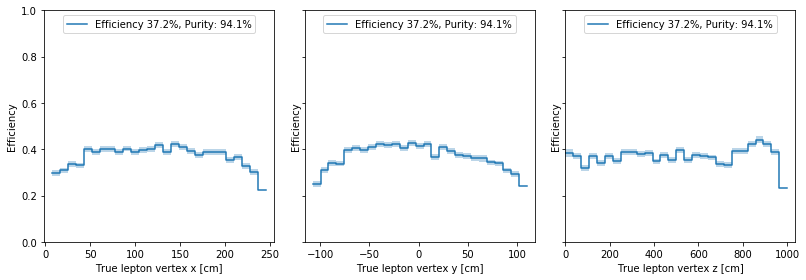

In [15]:
fig,ax=plt.subplots(ncols=3,nrows=1,figsize=(7*gr,4), sharey=True)
#lower = [-1.55, -115.53, 0.1]
#upper = [254.8, 117.47, 1036.9]
purity = pur_final
eff = eff_final
x_min = -1.55
x_max = 254.8
N = 29
denom = tree_Event['mc_nu_vx'][nu_sig_mask]
print 'The denominator', denom.shape
nom = tree_Daughter_nuCC.query(query_event)['mc_nu_vx']
print 'The nominator', nom.shape
data = [denom, nom]
edges, _, bins, _, _ = helper.histHelper(N,x_min,x_max,data)
fraq = bins[1]/bins[0]
err = np.sqrt( fraq*(1-fraq)/bins[0] )
fraq= np.append(fraq,fraq[-1])
err = np.append(err,err[-1]) 

ax[0].fill_between(edges, fraq - err, fraq + err, alpha=0.3, step='post')
ax[0].set_xlabel(r'True lepton vertex x [cm]')
ax[0].set_ylabel('Efficiency')
ax[0].set_ylim(0,1)
ax[0].set_xlim(x_min, x_max)
ax[0].step(edges, fraq, where='post', label = r'Efficiency {0:0.1f}%, Purity: {1:0.1f}%'.format(eff*100,purity*100))
ax[0].legend(loc='upper center')

# Right
x_min = -115.53
x_max = 117.47
N = 29
denom = tree_Event['mc_nu_vy'][nu_sig_mask]
print 'The denominator', denom.shape
nom = tree_Daughter_nuCC.query(query_event)['mc_nu_vy']
print 'The nominator', nom.shape
data = [denom, nom]
edges, _, bins, _, _ = helper.histHelper(N,x_min,x_max,data)
fraq = bins[1]/bins[0]
err = np.sqrt( fraq*(1-fraq)/bins[0] )
fraq= np.append(fraq,fraq[-1])
err = np.append(err,err[-1]) 

ax[1].fill_between(edges, fraq - err, fraq + err, alpha=0.3, step='post')
ax[1].set_xlabel(r'True lepton vertex y [cm]')
ax[1].set_ylabel('Efficiency')
ax[1].set_ylim(0,1)
ax[1].set_xlim(x_min, x_max)
ax[1].step(edges, fraq, where='post', label = r'Efficiency {0:0.1f}%, Purity: {1:0.1f}%'.format(eff*100,purity*100))
ax[1].legend(loc='upper center')

x_min = 0.1
x_max = 1036.9
N = 29
denom = tree_Event['mc_nu_vz'][nu_sig_mask]
print 'The denominator', denom.shape
nom = tree_Daughter_nuCC.query(query_event)['mc_nu_vz']
print 'The nominator', nom.shape
data = [denom, nom]
edges, _, bins, _, _ = helper.histHelper(N,x_min,x_max,data)
fraq = bins[1]/bins[0]
err = np.sqrt( fraq*(1-fraq)/bins[0] )
fraq= np.append(fraq,fraq[-1])
err = np.append(err,err[-1]) 

ax[2].fill_between(edges, fraq - err, fraq + err, alpha=0.3, step='post')
ax[2].set_xlabel(r'True lepton vertex z [cm]')
ax[2].set_ylabel('Efficiency')
ax[2].set_ylim(0,1)
ax[2].set_xlim(x_min, x_max)
ax[2].step(edges, fraq, where='post', label = r'Efficiency {0:0.1f}%, Purity: {1:0.1f}%'.format(eff*100,purity*100))
ax[2].legend(loc='upper center')

fig.tight_layout()
fig.savefig(outputdir+"eff.pdf", bbox_inches="tight")
fig.savefig(outputdir+"eff.png", bbox_inches="tight")

In [16]:
#query_event = 'nu_pdg==14 & (flashMatchScore<10 | topologicalScore>0.4) & start_contained & muon_candidate & topologicalScore>0.087 & (flashMatchScore/bestCosmicMatch)<4 & track_length>30 & minCRTdist>15'
for col in tree_Daughter_nuCC.columns: 
    print(col) 

event
run
subrun
evt_time_sec
evt_time_nsec
hitsU
hitsV
hitsY
caloU
caloV
caloY
hitsSps
generation
track_score
is_shower
is_track
has_shower_daughter
is_track_daughter
vx
vy
vz
vtx_distance
track_length
track_endx
track_endy
track_endz
track_dirx
track_diry
track_dirz
track_mcs_mom
track_mcs_err
track_mcs_ll
track_chi2_proton
track_chi2_muon
shower_length
shower_openangle
shower_dirx
shower_diry
shower_dirz
start_dedxU
start_dedxV
start_dedxY
start_hitsU
start_hitsV
start_hitsY
start_pitchU
start_pitchV
start_pitchY
mc_neutrino
mc_vx
mc_vy
mc_vz
mc_vx_sce
mc_vy_sce
mc_vz_sce
mc_length
mc_energy
mc_pdg
hash
nu_pdg
num_tracks
nu_sig_mask
topologicalScore
flashMatchScore
minCRTdist
longest_track_length
muon_candidate
all_muon_candidate
bestCosmicMatch
mc_nu_in_tpc
mc_nu_cc_sig
mc_nu_lepton_energy
mc_nu_lepton_theta
mc_nu_lepton_px
mc_nu_lepton_py
mc_nu_lepton_pz
mc_nu_vx
mc_nu_vy
mc_nu_vz
start_contained


The denominator (29531,)
The nominator (13833,)
The denominator (29531,)
The nominator (13833,)


/home/tmettler/.local/lib/python2.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


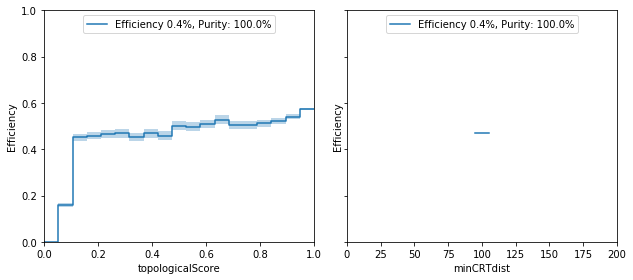

In [17]:
fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(5.5*gr,4), sharey=True)
purity = 1
x_min = 0
x_max = 1
N = 19

#denom = tree_Event['mc_nu_lepton_energy'][nu_sig_mask]
denom = tree_Daughter_nuCC.query('nu_sig_mask == 1 & muon_candidate')['topologicalScore']
#print (nu_sig_mask)
print 'The denominator', denom.shape
nom = tree_Daughter_nuCC.query(query_event)['topologicalScore']
print 'The nominator', nom.shape
data = [denom, nom]
edges, _, bins, _, _ = helper.histHelper(N,x_min,x_max,data)
fraq = bins[1]/bins[0]
err = np.sqrt( fraq*(1-fraq)/bins[0] )
fraq= np.append(fraq,fraq[-1])
err = np.append(err,err[-1]) 

ax[0].fill_between(edges, fraq - err, fraq + err, alpha=0.3, step='post')
ax[0].set_xlabel(r'topologicalScore')
ax[0].set_ylabel('Efficiency')
ax[0].set_ylim(0,1)
ax[0].set_xlim(x_min, x_max)
ax[0].step(edges, fraq, where='post', label = r'Efficiency {0:0.1f}%, Purity: {1:0.1f}%'.format(eff,purity*100))
ax[0].legend(loc='upper center')

# Right
x_min = 0
x_max = 200
#denom = tree_Event['mc_nu_lepton_energy'][nu_sig_mask]
denom = tree_Daughter_nuCC.query('nu_sig_mask == 1 & muon_candidate')['minCRTdist']
#print (nu_sig_mask)
print 'The denominator', denom.shape
nom = tree_Daughter_nuCC.query(query_event)['minCRTdist']
print 'The nominator', nom.shape
data = [denom, nom]
edges, _, bins, _, _ = helper.histHelper(N,x_min,x_max,data)
fraq = bins[1]/bins[0]
err = np.sqrt( fraq*(1-fraq)/bins[0] )
fraq= np.append(fraq,fraq[-1])
err = np.append(err,err[-1]) 

ax[1].fill_between(edges, fraq - err, fraq + err, alpha=0.3, step='post')
ax[1].set_xlabel(r'minCRTdist')
ax[1].set_ylabel('Efficiency')
ax[1].set_ylim(0,1)
ax[1].set_xlim(x_min, x_max)
ax[1].step(edges, fraq, where='post', label = r'Efficiency {0:0.1f}%, Purity: {1:0.1f}%'.format(eff,purity*100))
ax[1].legend(loc='upper center')



fig.tight_layout()
fig.savefig(outputdir+"eff.pdf", bbox_inches="tight")
fig.savefig(outputdir+"eff.png", bbox_inches="tight")

The denominator (29531,)
The nominator (13833,)
The denominator (29531,)
The nominator (13833,)


/home/tmettler/.local/lib/python2.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


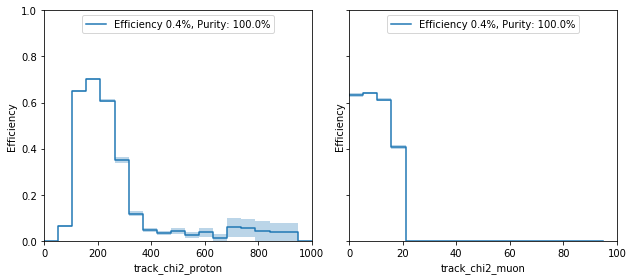

In [18]:
fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(5.5*gr,4), sharey=True)
purity = 1
x_min = 0
x_max = 1000
N = 19

#denom = tree_Event['mc_nu_lepton_energy'][nu_sig_mask]
denom = tree_Daughter_nuCC.query('nu_sig_mask == 1 & muon_candidate')['track_chi2_proton']
#print (nu_sig_mask)
print 'The denominator', denom.shape
nom = tree_Daughter_nuCC.query(query_event)['track_chi2_proton']
print 'The nominator', nom.shape
data = [denom, nom]
edges, _, bins, _, _ = helper.histHelper(N,x_min,x_max,data)
fraq = bins[1]/bins[0]
err = np.sqrt( fraq*(1-fraq)/bins[0] )
fraq= np.append(fraq,fraq[-1])
err = np.append(err,err[-1]) 

ax[0].fill_between(edges, fraq - err, fraq + err, alpha=0.3, step='post')
ax[0].set_xlabel(r'track_chi2_proton')
ax[0].set_ylabel('Efficiency')
ax[0].set_ylim(0,1)
ax[0].set_xlim(x_min, x_max)
ax[0].step(edges, fraq, where='post', label = r'Efficiency {0:0.1f}%, Purity: {1:0.1f}%'.format(eff,purity*100))
ax[0].legend(loc='upper center')

# Right
x_min = 0
x_max = 100
#denom = tree_Event['mc_nu_lepton_energy'][nu_sig_mask]
denom = tree_Daughter_nuCC.query('nu_sig_mask == 1 & muon_candidate')['track_chi2_muon']
#print (nu_sig_mask)
print 'The denominator', denom.shape
nom = tree_Daughter_nuCC.query(query_event)['track_chi2_muon']
print 'The nominator', nom.shape
data = [denom, nom]
edges, _, bins, _, _ = helper.histHelper(N,x_min,x_max,data)
fraq = bins[1]/bins[0]
err = np.sqrt( fraq*(1-fraq)/bins[0] )
fraq= np.append(fraq,fraq[-1])
err = np.append(err,err[-1]) 

ax[1].fill_between(edges, fraq - err, fraq + err, alpha=0.3, step='post')
ax[1].set_xlabel(r'track_chi2_muon')
ax[1].set_ylabel('Efficiency')
ax[1].set_ylim(0,1)
ax[1].set_xlim(x_min, x_max)
ax[1].step(edges, fraq, where='post', label = r'Efficiency {0:0.1f}%, Purity: {1:0.1f}%'.format(eff,purity*100))
ax[1].legend(loc='upper center')



fig.tight_layout()
fig.savefig(outputdir+"eff.pdf", bbox_inches="tight")
fig.savefig(outputdir+"eff.png", bbox_inches="tight")

In [19]:
import collections
#a = tree_Daughter_nuCC.query(query_event)['mc_pdg']
# 2212=proton , 211=Pi+, 11=electron, 2112=neutron, 321=K+, 22=gamma, 3222=sigma+
counter=collections.Counter(tree_Daughter_nuCC.query(query_event)['mc_pdg'])
print(counter)

print 'Initial nues in fiducial volume:', sum(tree_Event.eval('~mc_nu_ccnc & abs(mc_nu_pdg)==12 & mc_nu_fid_vol') )

Counter({13: 13016, 211: 280, 2212: 266, -13: 110, 2112: 85, -211: 48, 22: 25, 321: 2, 3222: 1})
Initial nues in fiducial volume: 264


event


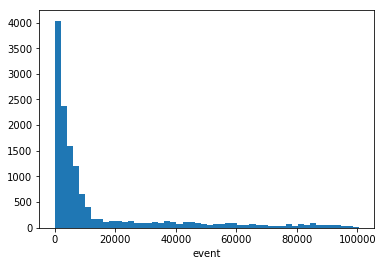

run


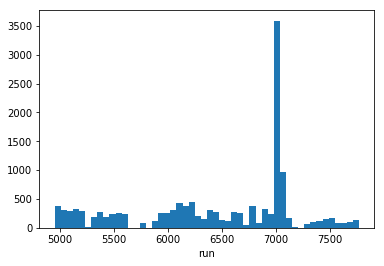

subrun


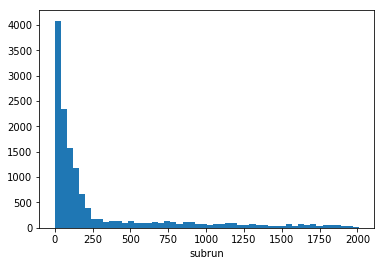

evt_time_sec


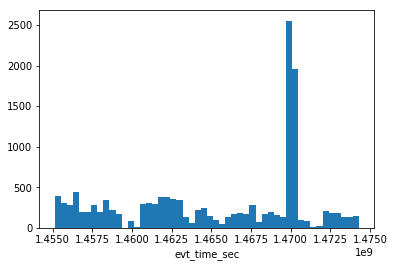

evt_time_nsec


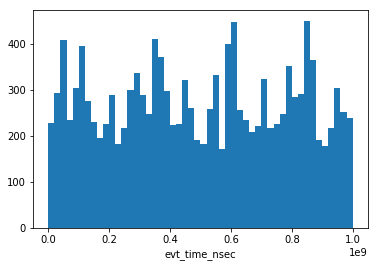

hitsU


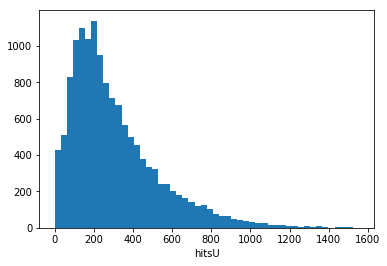

hitsV


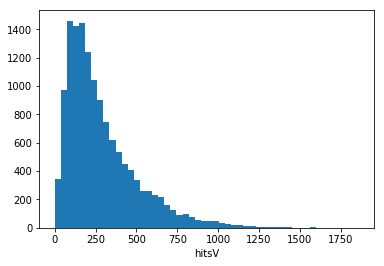

hitsY


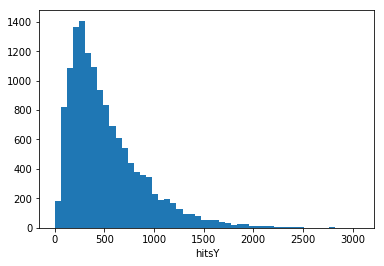

caloU


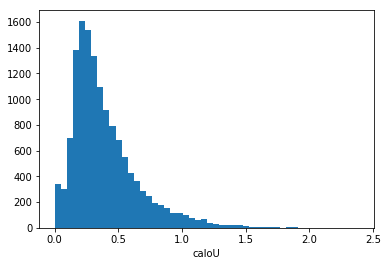

caloV


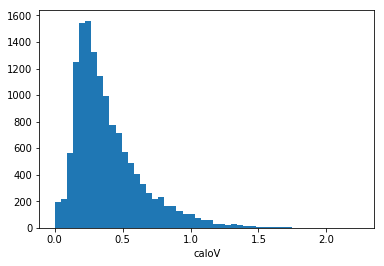

caloY


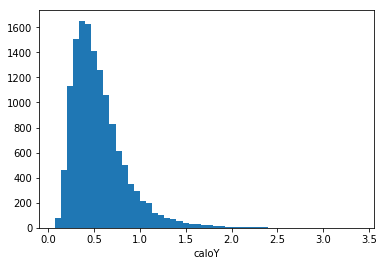

hitsSps


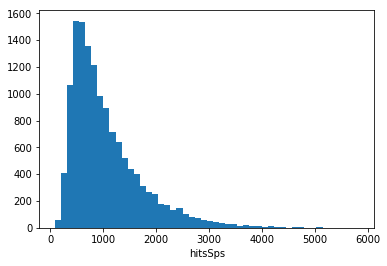

generation


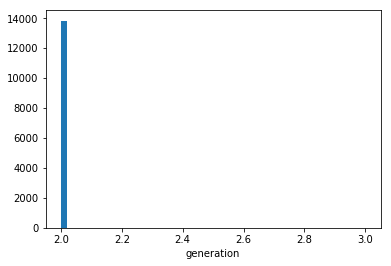

track_score


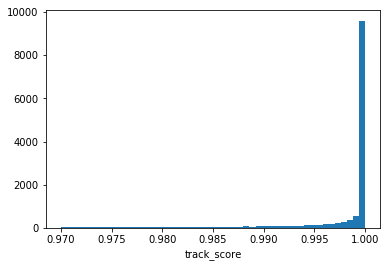

is_shower


/home/tmettler/.local/lib/python2.7/site-packages/numpy/lib/histograms.py:778: RuntimeWarning: Converting input from bool to <type 'numpy.uint8'> for compatibility.
  a, weights = _ravel_and_check_weights(a, weights)


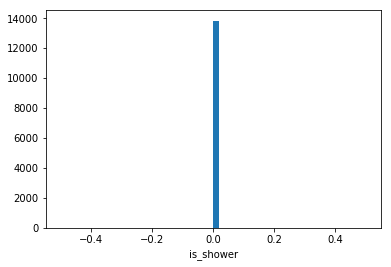

is_track


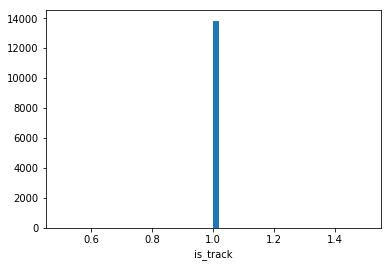

has_shower_daughter
is_track_daughter
vx


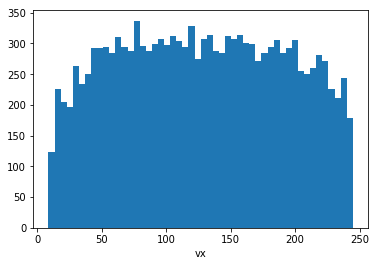

vy


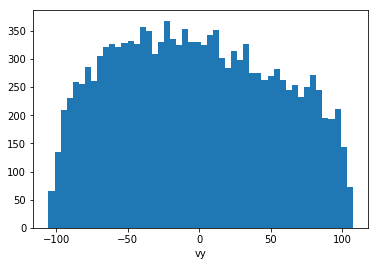

vz


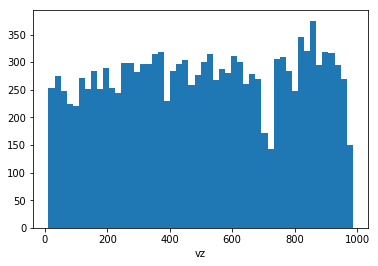

vtx_distance


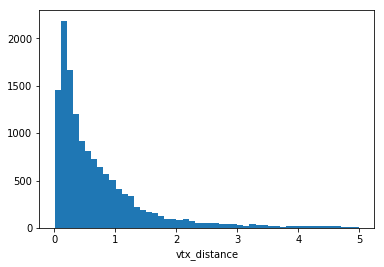

track_length


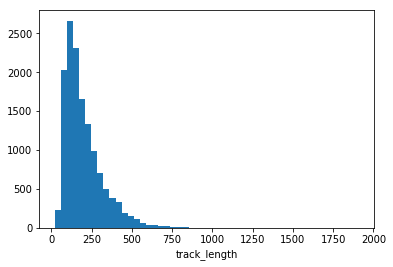

track_endx


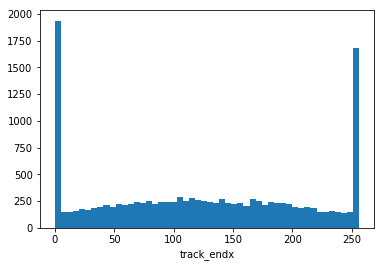

track_endy


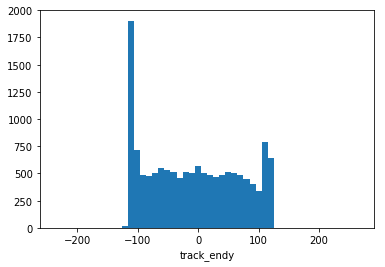

track_endz


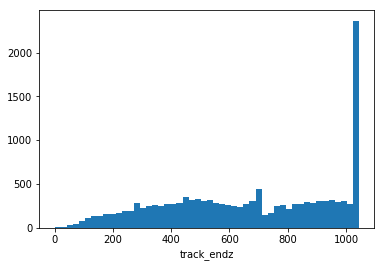

track_dirx


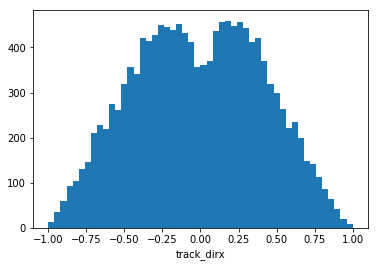

track_diry


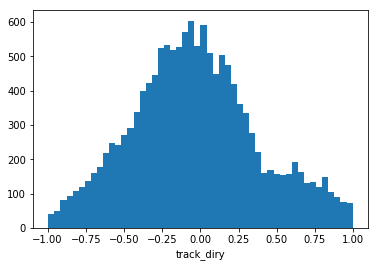

track_dirz


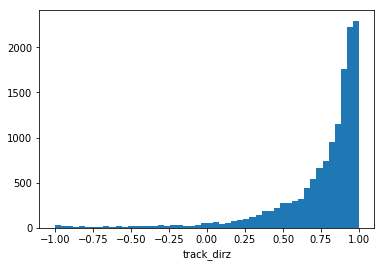

track_mcs_mom


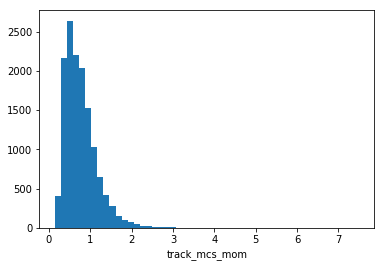

track_mcs_err
track_mcs_ll
track_chi2_proton


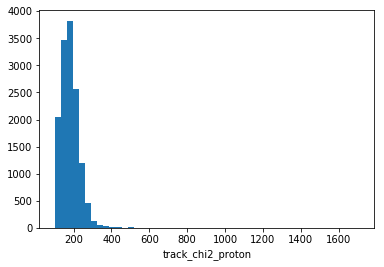

track_chi2_muon


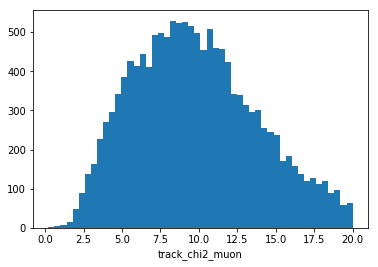

shower_length


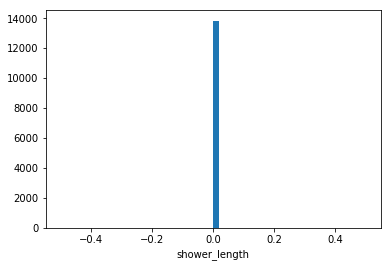

shower_openangle


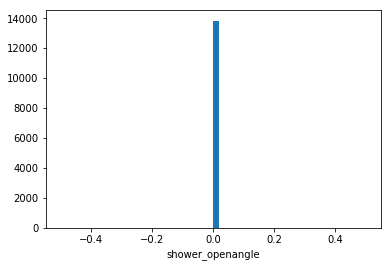

shower_dirx


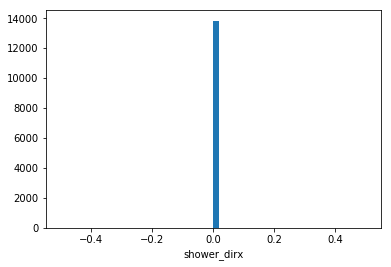

shower_diry


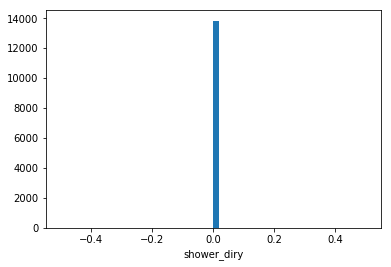

shower_dirz


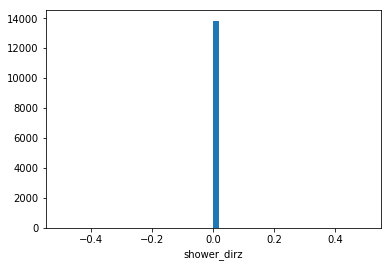

start_dedxU


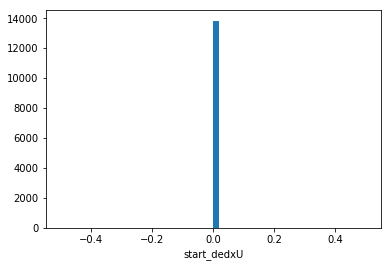

start_dedxV


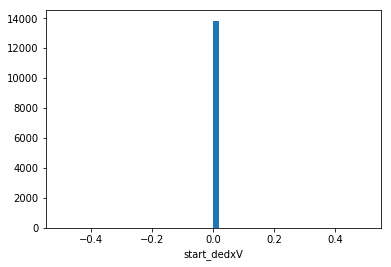

start_dedxY


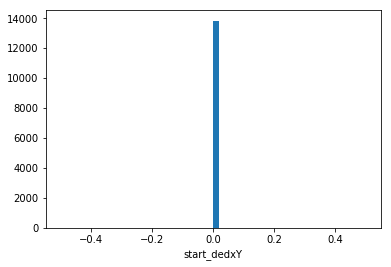

start_hitsU


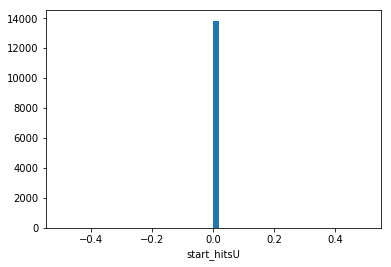

start_hitsV


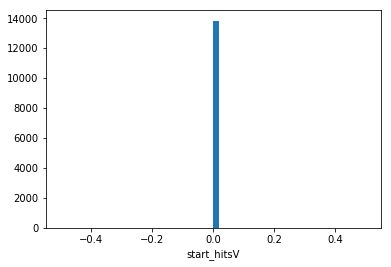

start_hitsY


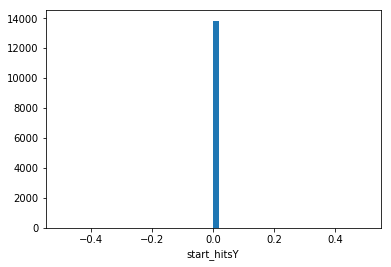

start_pitchU


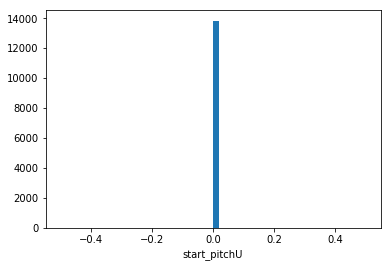

start_pitchV


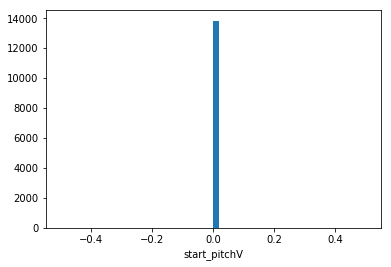

start_pitchY


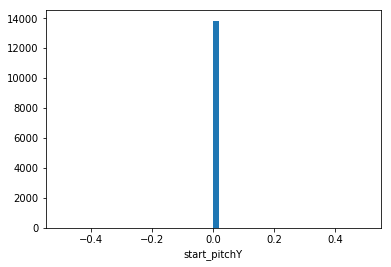

mc_neutrino


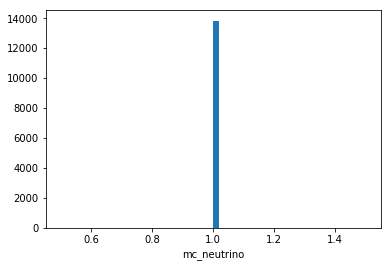

mc_vx


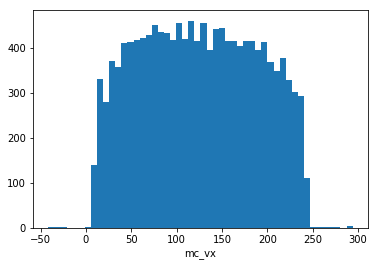

mc_vy


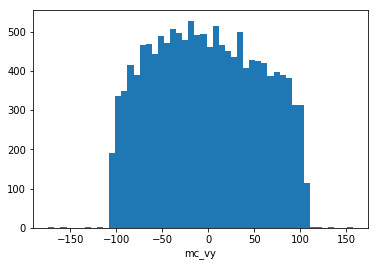

mc_vz


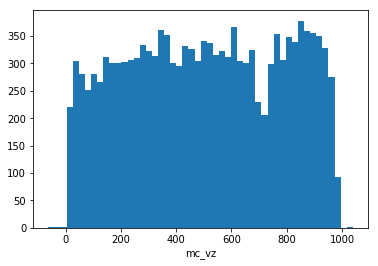

mc_vx_sce


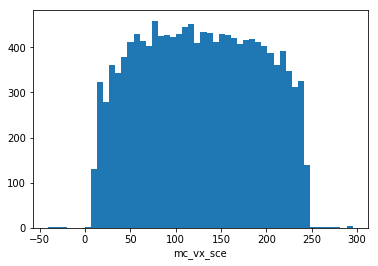

mc_vy_sce


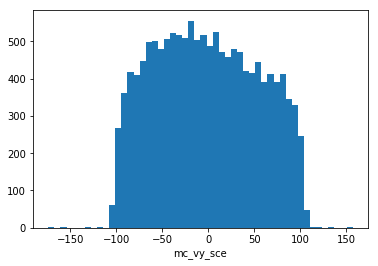

mc_vz_sce


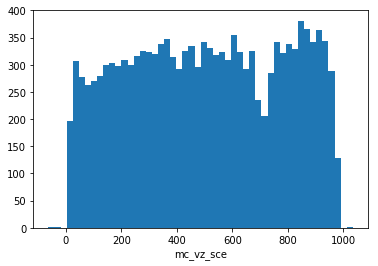

mc_length


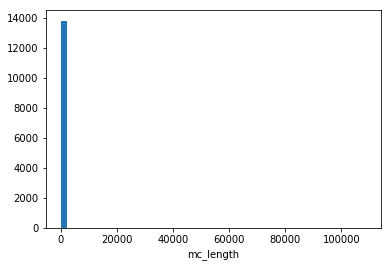

mc_energy


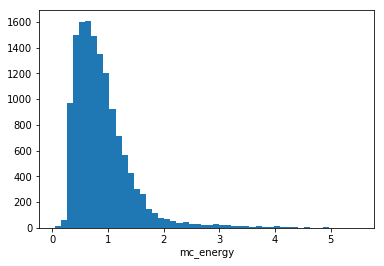

mc_pdg


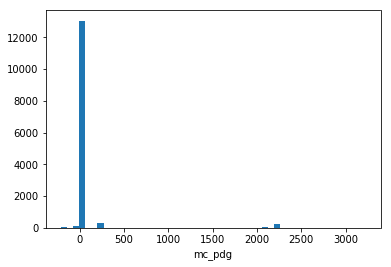

hash


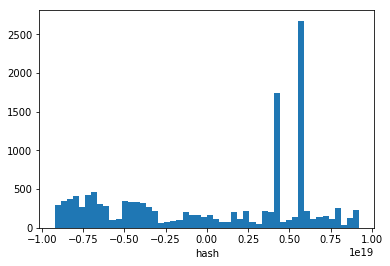

nu_pdg


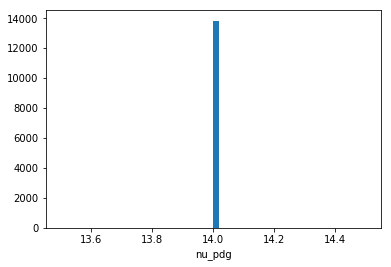

num_tracks


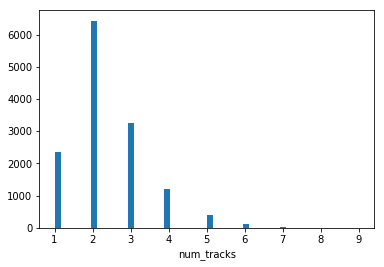

nu_sig_mask


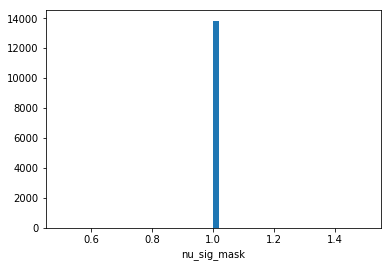

topologicalScore


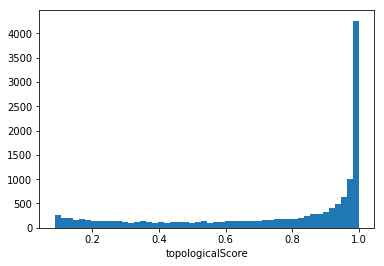

flashMatchScore


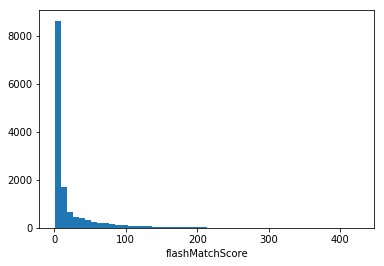

minCRTdist


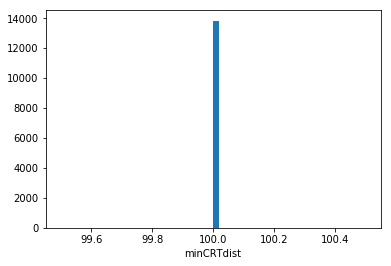

longest_track_length


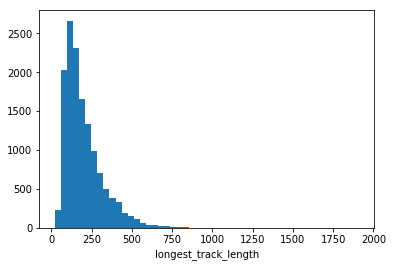

muon_candidate


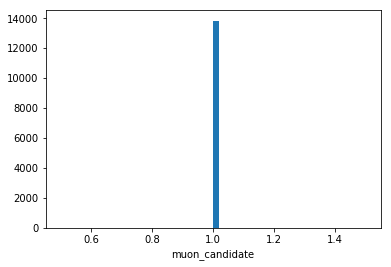

all_muon_candidate


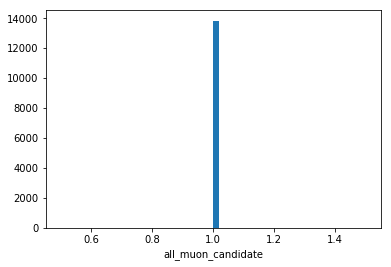

bestCosmicMatch


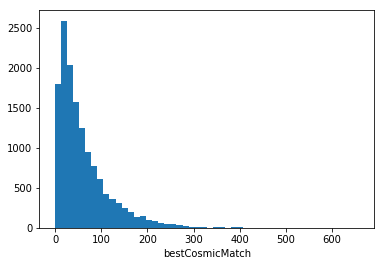

mc_nu_in_tpc


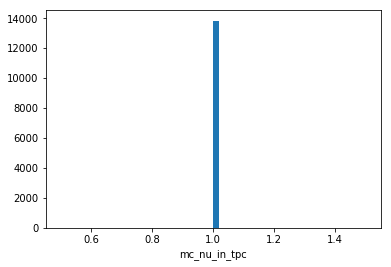

mc_nu_cc_sig


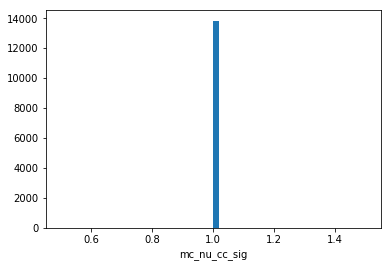

mc_nu_lepton_energy


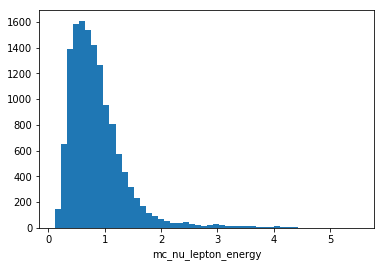

mc_nu_lepton_theta


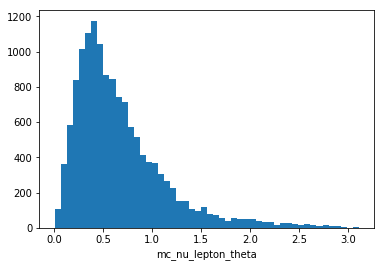

mc_nu_lepton_px


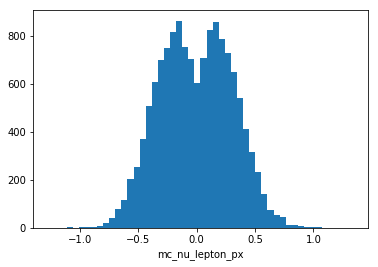

mc_nu_lepton_py


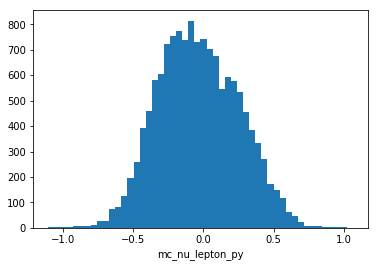

mc_nu_lepton_pz


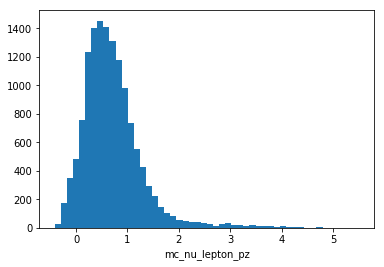

mc_nu_vx


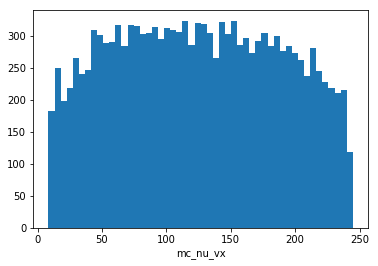

mc_nu_vy


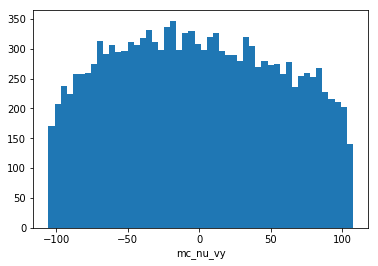

mc_nu_vz


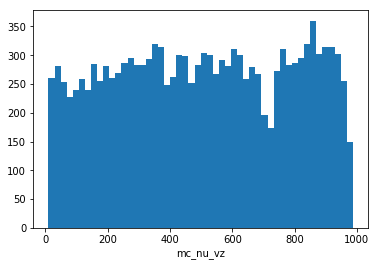

start_contained


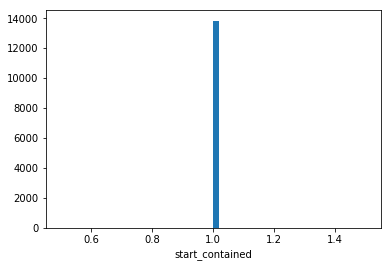

In [20]:
for key in tree_Daughter_nuCC.columns: 
    print key
    if (key!='has_shower_daughter' and key!='is_track_daughter' and key!='track_mcs_err' and key!='track_mcs_ll') :
        plt.hist(tree_Daughter_nuCC.query(query_event)[key.decode("utf-8")], bins=50)
        plt.xlabel(key.decode("utf-8"))
        plt.show()